### Neural Network: Imports

Imports for the Multi-Layer Perceptron and Back Propagation Neural Network

What does each one do? 
- numpy for arrays
- pandas for data manipulation and preparation
- matplotlib for tabelling and graph plotting
- sklearn for ML streamlining, and stat modelling

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


### Load PCA-Reduced Data:

- function train = reading the post PCA training file
- function val = reading the post PCA transformed validation file
- function test = reading the post PCA transformed test file

In [3]:
train = pd.read_csv("train_reduced_gA.csv")
val   = pd.read_csv("validation_reduced_gA.csv")
test  = pd.read_csv("test_reduced_gA.csv")

print("Train shape:", train.shape)
print("Validation shape:", val.shape)
print("Test shape:", test.shape)
print("\nColumns:", train.columns)

X_train = train[["PC1", "PC2"]].values
y_train = train["taxi_time"].values.reshape(-1, 1)

X_val = val[["PC1", "PC2"]].values
y_val = val["taxi_time"].values.reshape(-1, 1)

X_test = test[["PC1", "PC2"]].values
y_test = test["taxi_time"].values.reshape(-1, 1)


Train shape: (4728, 3)
Validation shape: (1351, 3)
Test shape: (676, 3)

Columns: Index(['PC1', 'PC2', 'taxi_time'], dtype='object')


### Normalisation of X Features:

standardising mean 0, standard deviation 1 / matrix scaling

In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

print("Scaled shapes:", X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape)
print("\nColumns:", X_train_scaled)


Scaled shapes: (4728, 2) (1351, 2) (676, 2)

Columns: [[-0.51614669 -1.02317286]
 [-0.82951825 -0.53599244]
 [ 2.1169776  -1.17169039]
 ...
 [ 0.36635624 -1.9464009 ]
 [ 1.29204692 -0.88530342]
 [ 0.01973267 -1.71333614]]


### Activations:

sigmoid and derivative of sigmoid

In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def d_sigmoid(x):
    s = sigmoid(x)
    return s * (1 - s)


### Backpropagations (BP):

2 -> H -> 1 network with: 
- bias included by extending inputs and hidden activations
- sigmoid in hidden layer
- linear output (for regression)

In [ ]:
class MLP_BPNN:

    def __init__(self, n_in, n_hidden, n_out=1, lr=0.01, random_state=42):
        np.random.seed(random_state)
        self.n_in = n_in
        self.n_hidden = n_hidden
        self.n_out = n_out
        self.lr = lr

        # +1 for bias in each layer
        # W1: (n_in + 1, n_hidden)
        self.W1 = np.random.randn(n_in + 1, n_hidden) * np.sqrt(2 / (n_in + 1))

        # W2: (n_hidden + 1, n_out)
        self.W2 = np.random.randn(n_hidden + 1, n_out) * np.sqrt(2 / (n_hidden + 1))

    def _forward(self, x):
        # Add bias to input: x_b
        x_b = np.hstack([1.0, x])  

        # Hidden layer
        z1 = x_b @ self.W1
        h = sigmoid(z1)

        # Add bias to hidden
        h_b = np.hstack([1.0, h])

        # Output layer (linear)
        z2 = h_b @ self.W2
        y_pred = z2

        cache = (x_b, z1, h, h_b, z2)
        return y_pred, cache

    def _backward(self, y_pred, y_true, cache):
        x_b, z1, h, h_b, z2 = cache

        # Shape to check 1D
        y_pred = np.array(y_pred).reshape(-1)
        y_true = np.array(y_true).reshape(-1)

        # dL/dy_pred = (y_pred - y_true)
        delta_out = (y_pred - y_true)

        # Gradients for W2: outer(h_b, delta_out)
        dW2 = np.outer(h_b, delta_out)

        # BP
        # W2 without bias row: shape (n_hidden, n_out)
        W2_no_bias = self.W2[1:, :]            
        delta_hidden = (W2_no_bias @ delta_out) * d_sigmoid(z1)

        # Gradients for W1: outer(x_b, delta_hidden)
        dW1 = np.outer(x_b, delta_hidden)
        return dW1, dW2

    def fit(self, X, y, X_val=None, y_val=None, X_test=None, y_test=None, epochs=1000, verbose=True):
        """
        X: (N, n_in)
        y: (N, 1)
        """
        N = X.shape[0]
        train_losses = []
        val_losses = []
        test_losses = []

        for epoch in range(epochs):
            dW1_sum = np.zeros_like(self.W1)
            dW2_sum = np.zeros_like(self.W2)
            loss = 0.0

            for i in range(N):
                x_i = X[i]
                y_i = y[i]

                y_pred, cache = self._forward(x_i)
                loss += 0.5 * np.sum((y_pred - y_i)**2)

                dW1, dW2 = self._backward(y_pred, y_i, cache)
                dW1_sum += dW1
                dW2_sum += dW2


            self.W1 -= self.lr * dW1_sum / N
            self.W2 -= self.lr * dW2_sum / N

            train_losses.append(loss / N)


            if X_val is not None and y_val is not None:
                val_loss = 0.0
                for i in range(X_val.shape[0]):
                    y_p, _ = self._forward(X_val[i])
                    val_loss += 0.5 * np.sum((y_p - y_val[i])**2)
                val_losses.append(val_loss / X_val.shape[0])
            

            if X_test is not None and y_test is not None:
                test_loss = 0.0
                for i in range(X_test.shape[0]):
                    y_p, _ = self._forward(X_test[i])
                    test_loss += 0.5 * np.sum((y_p - y_test[i])**2)
                test_losses.append(test_loss / X_test.shape[0])

            if verbose and epoch % 100 == 0:
                print(f"Epoch {epoch}, MSE = {loss / N:.4f}")

        return train_losses, val_losses, test_losses

    def predict(self, X):
        """
        X: (N, n_in)
        returns: (N,) predictions
        """
        preds = []
        for i in range(X.shape[0]):
            y_pred, _ = self._forward(X[i])
            preds.append(y_pred.item())
        return np.array(preds)


### Create and Train the Network:

one full pass through the entire training dataset.

basically, passes through 4728 samples, processes, forward prop + back prop, update weights on batch at time, 1000 times 

- n_in = 2  (two principal components selected through PCA)
- n_hidden = 12 (was chosen to provide sufficient model capacity without overfitting; this value can be adjusted as part of hyperparameter tuning)
- lr = 0.01 (Learning Rate controls the step size of gradient descent updates)
- epochs = 1000 (model performs 1000 full passes over the training dataset, for the network to converge)
- The model trains using backpropagation via the MLP_BPNN class.

In [ ]:
n_in = X_train_scaled.shape[1]
n_hidden = 12
lr = 0.01
epochs = 1000

nn = MLP_BPNN(n_in=n_in, n_hidden=n_hidden, n_out=1, lr=lr, random_state=42)

train_losses, val_losses, test_losses = nn.fit(
    X_train_scaled, y_train, 
    X_val=X_val_scaled, y_val=y_val,
    X_test=X_test_scaled, y_test=y_test,
    epochs=epochs, verbose=True
)


Epoch 0, MSE = 54.0465
Epoch 100, MSE = 8.0338
Epoch 200, MSE = 6.0115
Epoch 300, MSE = 5.5228
Epoch 400, MSE = 5.4218
Epoch 500, MSE = 5.4003
Epoch 600, MSE = 5.3936
Epoch 700, MSE = 5.3896
Epoch 800, MSE = 5.3862
Epoch 900, MSE = 5.3831


### Evaluate on Train / Validation / Test:

RMSE - Measures the average magnitude of prediction error. Lower values indicate better performance.

MAE - Provides the average absolute difference between predicted and actual taxi times.

R² - Indicates how much variance in the target variable is explained by the model. / Values closer to 1 represent better predictive accuracy.

The model's performance is evaluated separately on the training, validation, and test sets to assess:
- fit quality (training performance)
- hyperparameter selection (validation performance)
- generalisation ability (test performance)


In [ ]:
y_train_pred = nn.predict(X_train_scaled)
y_val_pred   = nn.predict(X_val_scaled)
y_test_pred  = nn.predict(X_test_scaled)

def print_metrics(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"\n{name} set:")
    print(f"  RMSE = {rmse:.4f}")
    print(f"  MAE  = {mae:.4f}")
    print(f"  R²   = {r2:.4f}")
    return rmse, mae, r2

rmse_tr, mae_tr, r2_tr = print_metrics("Train", y_train, y_train_pred)
rmse_va, mae_va, r2_va = print_metrics("Validation", y_val, y_val_pred)
rmse_te, mae_te, r2_te = print_metrics("Test", y_test, y_test_pred)



Train set:
  RMSE = 3.2803
  MAE  = 2.5683
  R²   = 0.4861

Validation set:
  RMSE = 3.3336
  MAE  = 2.5765
  R²   = 0.4731

Test set:
  RMSE = 3.3243
  MAE  = 2.6138
  R²   = 0.4590

Loss Values set:
Final Train Loss: 5.3803
Final Val Loss:   5.5565
Final Test Loss:  5.5256


### 1. Plot Training, Validation, and Testing Loss

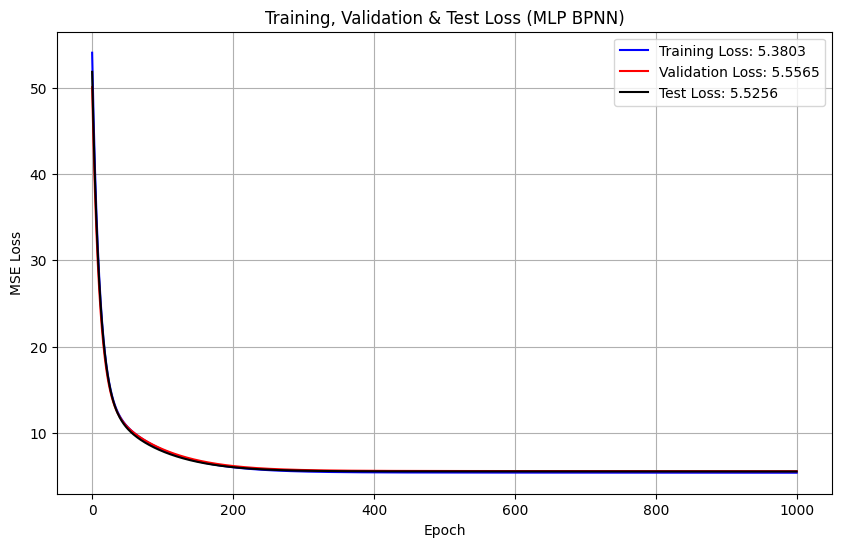

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label=f"Training Loss: {train_losses[-1]:.4f}", color='blue')
plt.plot(val_losses, label=f"Validation Loss: {val_losses[-1]:.4f}", color='red')
plt.plot(test_losses, label=f"Test Loss: {test_losses[-1]:.4f}", color='black')

plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training, Validation & Test Loss (MLP BPNN)")
plt.legend(loc="upper right")
plt.grid(True)
plt.savefig("MLP_BPNN_Loss_Curves.png")
plt.show()

### 2. Predicted vs Actual

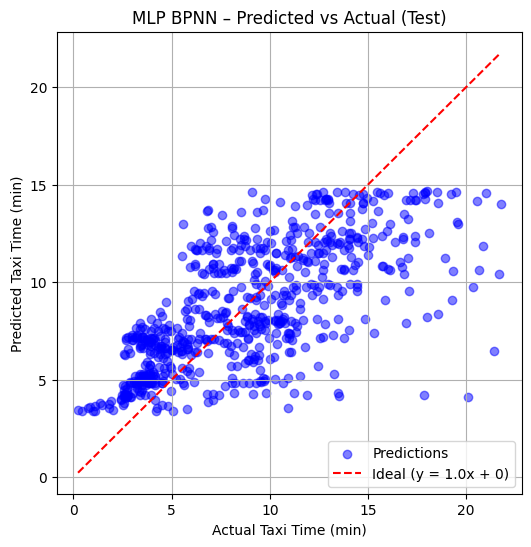

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred, alpha=0.5, color='blue', label="Predictions")
min_tt = min(y_test.min(), y_test_pred.min())
max_tt = max(y_test.max(), y_test_pred.max())

plt.plot([min_tt, max_tt], [min_tt, max_tt], 'r--', label="Ideal (y = 1.0x + 0)")

plt.xlabel("Actual Taxi Time (min)")
plt.ylabel("Predicted Taxi Time (min)")
plt.title("MLP BPNN – Predicted vs Actual (Test)")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("MLP_BPNN_Predicted_vs_Actual_Test.png")
plt.show()

### 3. Distributions of Residuals

Residual Mean: 0.1506 (Ideal: ~0.0)
Residual Std Dev: 3.3209


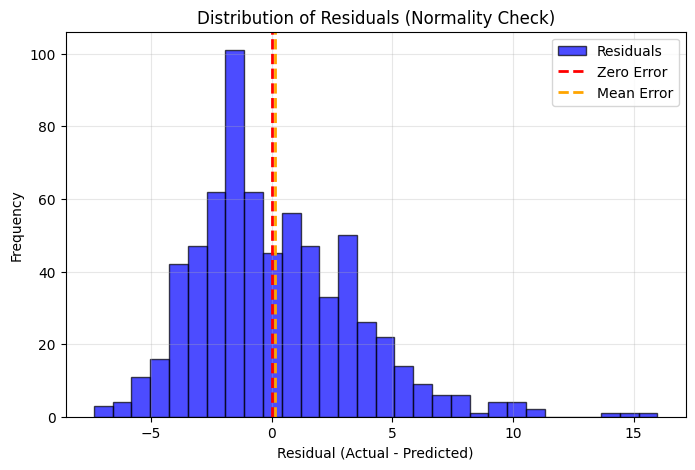

In [ ]:
residuals = y_test.flatten() - y_test_pred
res_mean = np.mean(residuals)
res_std = np.std(residuals)

print(f"Residual Mean: {res_mean:.4f} (Ideal: ~0.0)")
print(f"Residual Std Dev: {res_std:.4f}")


plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='blue', label="Residuals")
plt.axvline(0, color='red', linestyle='dashed', linewidth=2, label="Zero Error")
plt.axvline(res_mean, color='orange', linestyle='dashed', linewidth=2, label="Mean Error")

plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals (Normality Check)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("MLP_BPNN_Residual_Histogram.png")
plt.show()

### 4. Residual Plot

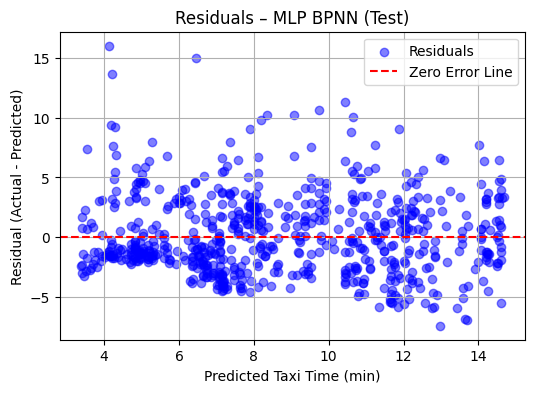

In [ ]:
residuals = y_test.flatten() - y_test_pred

plt.figure(figsize=(6,4))
plt.scatter(y_test_pred, residuals, alpha=0.5, color='blue', label="Residuals")
plt.axhline(0, color="red", linestyle="--", label="Zero Error Line")

plt.xlabel("Predicted Taxi Time (min)")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals – MLP BPNN (Test)")
plt.grid(True)
plt.legend()
plt.savefig("MLP_BPNN_Residuals_Test.png", dpi=300, bbox_inches="tight")
plt.show()